<h1 style="text-align: center;">Predicting Potential Credit Risks</h1>
<h3 style="text-align: center;">Spring 2024 Data Science Project</h3>
<p style="text-align: center;">Collaborators: Keenan Powell and Anirudh Satheesh</p>
<hr></hr>


<h2 style="text-align: center;">Introduction</h2>
The purpose of this project is to understand and predict which people can be considered as good and bad credit risks. Essentially, a good credit risk means that this person has a low likelihood of defaulting on any potential loans, or that they will not pay the entire loan. This is an important problem because bad credit risks can induce significant financial stress on banks to make up for the money loaned, often by raising the interest rates on other loans to compensate. For example, the Federal Reserve reports that 1.43% of Americans still default on their loans, and while this number is on the decline, insightful data analytics can further help banks avoid bad potential credit risks (FEDR, 2023).

To deal with classifying bad credit risks, we gather several features about each individual in our dataset, such as their employment status, duration with the bank, and credit history, and ask how they correlate with credit risk. For example, we ask does the employment status of the individual have a significant effect on being a credit risk? Does a lower credit amount correspond with a good or bad credit risk? Asking such questions allows us to gain valuble insights on such potential risks, and can allow banks to better allocate their resources for everyone.

Our project is split into 5 stages:
1. Data Collection
2. Data Preprocessing
3. Machine Learning Analysis / Hypothesis Testing
4. Visualizations
5. Insights / Conclusions
<hr></hr>

<h2 style="text-align: center;">Data Collection</h2>
For this project, we use several libraries to aid our data analysis, the main ones being pandas for storing and processing the data and openml, an online platform that helps researchers and data analysts to find and curate datasets and machine learning models.

We list the functionalities of each of the imports we use below:

<b>openml</b>: Used to download the dataset and additional important metadata, such as the type of each feature.

<b>pandas</b>: Used to manipulate / analyze the dataset by converting to dataframe, also used in hypothesis testing.

<b>numpy</b>: Used for helpful math functions and handling large array sizes.

<b>matplotlib</b>: Used to create plots to help analyze and demonstrate aspects about the dataset.

<b>sklearn</b>: Used to for general data preprocessing, such as developing encodings and performing transformations.

<b>scipy</b>: Used for hypothesis testing.

In [36]:
import openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from scipy.stats import ttest_ind, chi2_contingency

The dataset used in this project is the [credit-g dataset](https://www.openml.org/search?type=task&sort=runs&id=31), which is a binary classification dataset that has 1000 datapoints and 21 features, which includes an individual's checking account status, saving account status, duration with the bank, etc.

In [37]:
# get credit-g dataset with ID 31
dataset = openml.datasets.get_dataset(31)

# extract input, targets, and categorical indicator
df, target, categorical_indicator, _ = dataset.get_data(target=dataset.default_target_attribute)
df.head()

/tmp/ipykernel_397294/3980705183.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(31)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


<hr></hr>
<h2 style="text-align: center;">Data Processing</h2>

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   uint8   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   uint8   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   uint8   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   uint8   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [39]:
# Seperate the columns of the dataset into categorical and continuous subsets.
categorical_features = [i for i in categorical_indicator*df.columns if i != '']
categorical_features += ['installment_commitment', 'residence_since', 'existing_credits', 'num_dependents']
print(f"Categorical features:")
for index, i in enumerate(categorical_features):
    print(f"{index+1}) {i}")

Categorical features:
1) checking_status
2) credit_history
3) purpose
4) savings_status
5) employment
6) personal_status
7) other_parties
8) property_magnitude
9) other_payment_plans
10) housing
11) job
12) own_telephone
13) foreign_worker
14) installment_commitment
15) residence_since
16) existing_credits
17) num_dependents


In [40]:
continuous_features = [i for i in df.columns if i not in categorical_features]
print(f"Continuous features:")
for index, i in enumerate(continuous_features):
    print(f"{index+1}) {i}")

Continuous features:
1) duration
2) credit_amount
3) age


<b>Generate Encodings for Categorical Data</b>

In [41]:
# LabelEncoder converts "target" from an array of "good" and "bad" to an array of 1 and 0 
# so it can more easily be analyzed and compared to other variables. 
target = LabelEncoder().fit_transform(target)
df['class'] = target

In [42]:
feature_maps = {
    'checking_status': {'no checking': 0, '<0': -1, '0<=X<200': 1, '>=200': 2},
    'credit_history': {'no credits/all paid': 2, 'all paid': 1, 'existing paid': 0, 'critical/other existing credit': -1, 'delayed previously': -2},
    'savings_status': {'no known savings': 0, '<100': -1, '100<=X<500': 1, '500<=X<1000': 2, '>=1000': 3},
    'employment': {'unemployed': -1, '<1': 0, '1<=X<4': 1, '4<=X<7': 2, '>=7': 3},
    'job': {'unemp/unskilled non res': 0, 'high qualif/self emp/mgmt': 1, 'unskilled resident': 2, 'skilled': 3},
}
for col in feature_maps:
    df[col] = df[col].map(feature_maps[col]).astype('int')

In [43]:
other_categorical_features = list(set(categorical_features) - set(feature_maps.keys()))
for i in other_categorical_features:
    df[i] = OrdinalEncoder().fit_transform(df[i].values.reshape(-1, 1)).astype('int')

<b>Transform Continuous Features</b>

Unlike the previous categorical features, transforming the continuous features depends on how the features are distributed over the dataset.

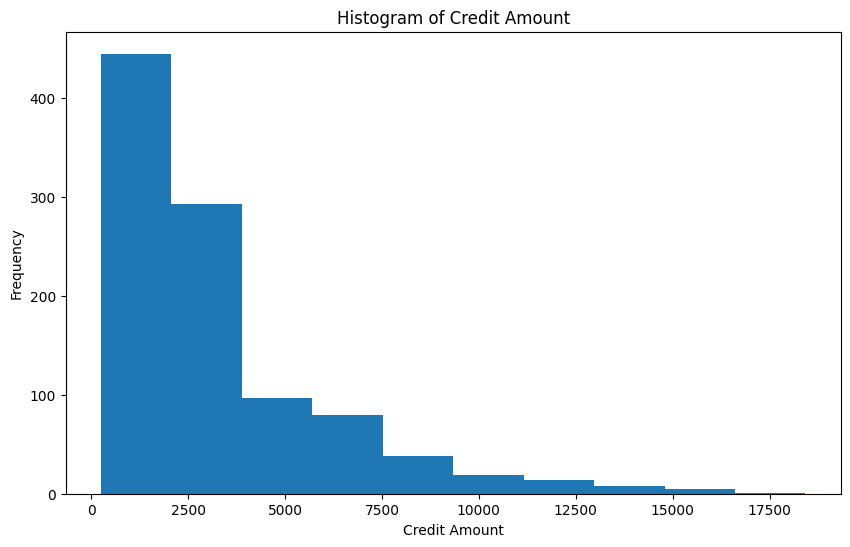

In [44]:
# plot credit amount in histogram
plt.figure(figsize=(10,6))
hist = plt.hist(df['credit_amount'], bins=10)
plt.title('Histogram of Credit Amount')
plt.xlabel('Credit Amount')
plt.ylabel('Frequency')
plt.show()

This distribution is very right skewed, so we should apply a log transform.

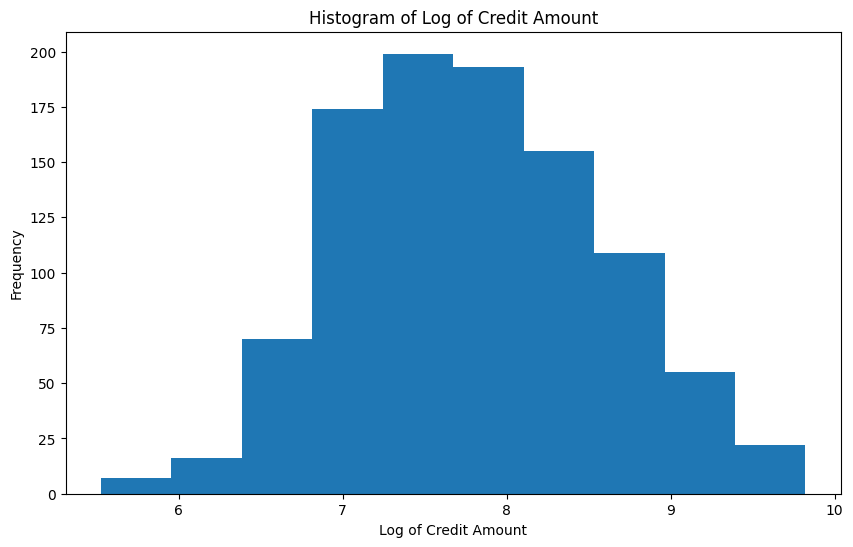

In [45]:
# apply log transform on credit amount and plot the log histogram
df['credit_amount'] = np.log1p(df['credit_amount'])
plt.figure(figsize=(10,6))
hist = plt.hist(df['credit_amount'], bins=10)
plt.title('Histogram of Log of Credit Amount')
plt.xlabel('Log of Credit Amount')
plt.ylabel('Frequency')
plt.show()

This is very similar to a normal distribution, which is what we want. We can perform a similar process for age and duration.

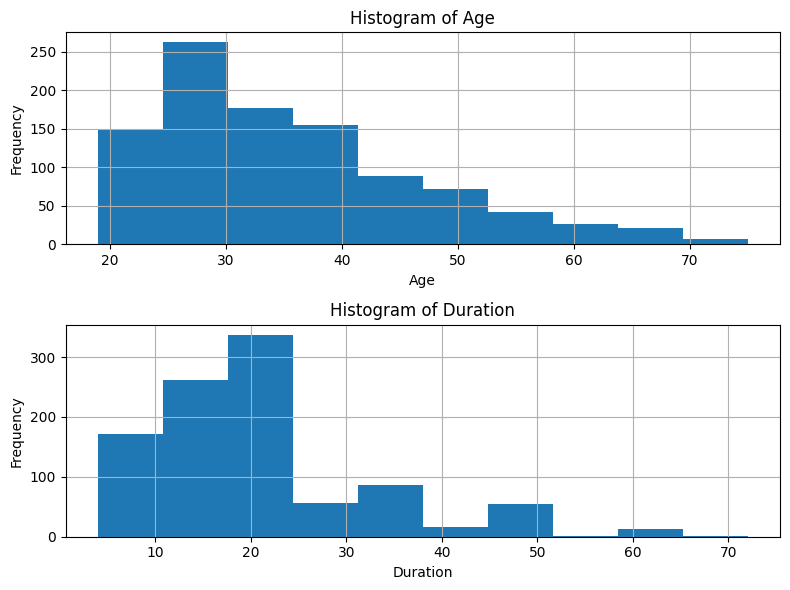

In [46]:
# plot age and duration in seperate histograms next to each other
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
df['age'].hist(ax=axes[0])
axes[0].set_title('Histogram of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
df['duration'].hist(ax=axes[1])
axes[1].set_title('Histogram of Duration')
axes[1].set_xlabel('Duration')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

From the plots, we can see that the distributions of both age and duration are similar to the credit amount, they are both right skewed, so we can use log transforms again to transform these distributions closer to normal distributions.

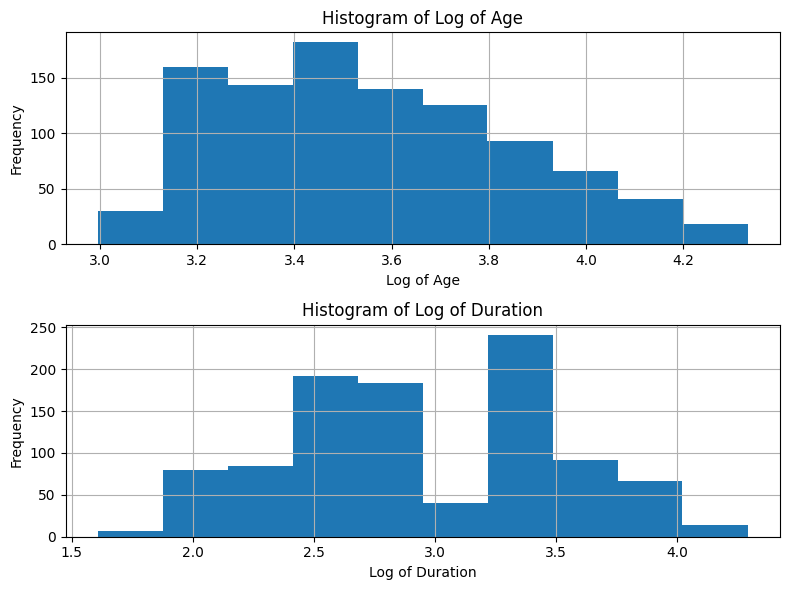

In [47]:
# apply log transform on duration and age and plot the log histograms
df['duration'] = np.log1p(df['duration'])
df['age'] = np.log1p(df['age'])
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
df['age'].hist(ax=axes[0])
axes[0].set_title('Histogram of Log of Age')
axes[0].set_xlabel('Log of Age')
axes[0].set_ylabel('Frequency')
df['duration'].hist(ax=axes[1])
axes[1].set_title('Histogram of Log of Duration')
axes[1].set_xlabel('Log of Duration')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

<hr></hr>
<h2 style="text-align: center;">Hypothesis Testing and Machine Learning Analysis</h2>

### Hypothesis Test #1: Does the type of job have a significant effect on the type of credit risk?

H<sub>0</sub>: The type of job has no significant effect on the type of credit risk.

H<sub>a</sub>: The type of job has a significant effect on the type of credit risk.

In [48]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['job'], df['class']))
p

0.5965815918843431

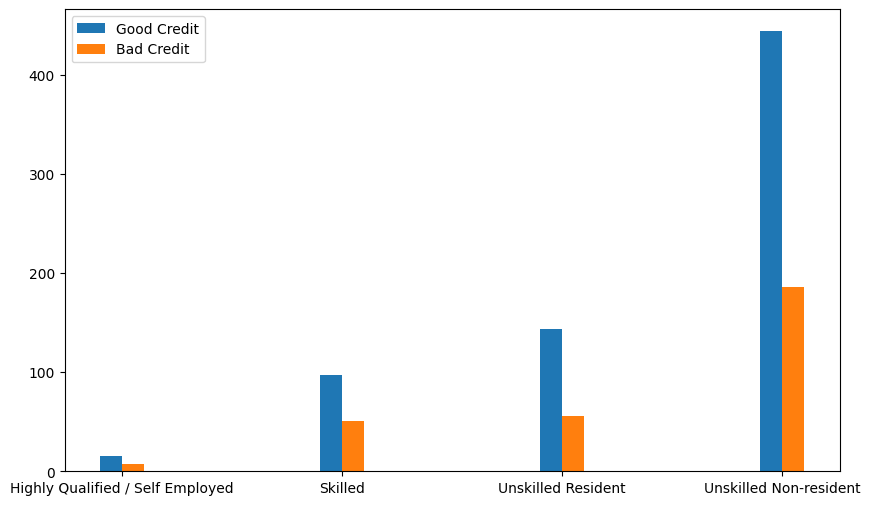

In [49]:
blue_bar = list(df[df['class'] == 1].groupby('job').size())
orange_bar = list(df[df['class'] == 0].groupby('job').size())
fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(4)
width = 0.1       
plt.bar(ind, blue_bar , 0.1, label='Good Credit')
plt.bar(ind + 0.1, orange_bar, width, label='Bad Credit')
plt.xticks(ind + 0.05, ['Highly Qualified / Self Employed', 'Skilled', 'Unskilled Resident', 'Unskilled Non-resident'])
plt.legend(loc='best')
plt.show()

### Conclusion
Since the p-value of 0.597 is greater than the alpha threshold of 0.05, we fail to reject the null hypothesis that the type of job has no significant effect on the type of credit risk.

### Hypothesis Test #2: Is the average credit amount lower for good credit risks vs bad credit risks?

Let $\sigma$<sub>g</sub> be the mean credit amount for those who are classified as a good credit risk and let $\sigma$<sub>b</sub> be the mean credit amount for those who are classified as a bad credit risk.

H<sub>0</sub>: $\sigma$<sub>g</sub> = $\sigma$<sub>b</sub>

H<sub>a</sub>: $\sigma$<sub>g</sub> < $\sigma$<sub>b</sub>

In [50]:
# Find credit amount for good and bad risks (perform exponential to reverse log transform before)
good_credit_amount = np.exp(df[df['class'] == 1]['credit_amount'])
bad_credit_amount = np.exp(df[df['class'] == 0]['credit_amount'])
t_statistic, p_value = ttest_ind(good_credit_amount, bad_credit_amount, alternative='less')
p_value


4.3987861867644465e-07

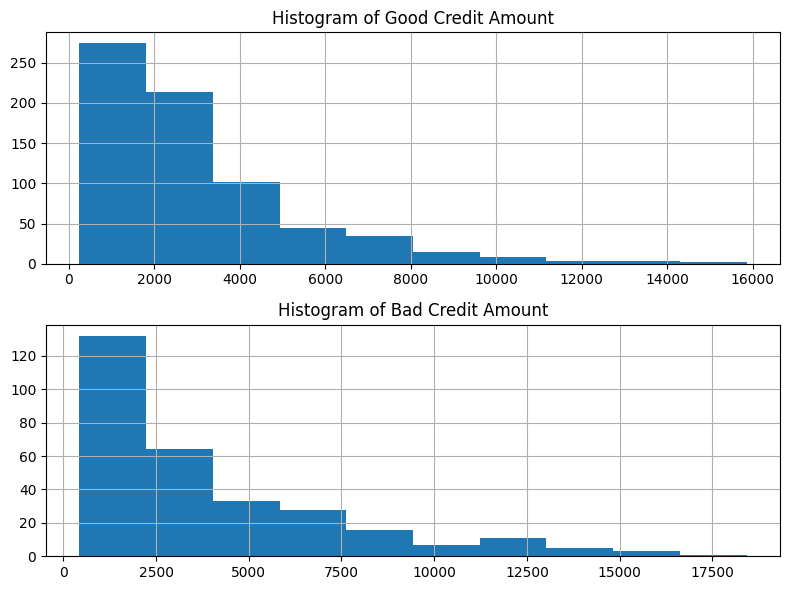

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
good_credit_amount.hist(ax=axes[0])
axes[0].set_title('Histogram of Good Credit Amount')
bad_credit_amount.hist(ax=axes[1])
axes[1].set_title('Histogram of Bad Credit Amount')
plt.tight_layout()
plt.show()


## Conclusion
Since the p-value of 4.398e-07 is less than the alpha threshold of 0.05, we have sufficient evidence to reject the null hypothesis that the mean credit amount is the same between those that are good credit risks and bad credit risks.

### Hypothesis Test #3: Is the average duration lower for good credit risks vs bad credit risks?

Let $\sigma$<sub>g</sub> be the mean duration for those who are classified as a good credit risk and let $\sigma$<sub>b</sub> be the mean duration for those who are classified as a bad credit risk.

H<sub>0</sub>: $\sigma$<sub>g</sub> = $\sigma$<sub>b</sub>

H<sub>a</sub>: $\sigma$<sub>g</sub> < $\sigma$<sub>b</sub>

In [52]:
good_duration = np.exp(df[df['class'] == 1]['duration'])
bad_duration = np.exp(df[df['class'] == 0]['duration'])
t_statistic, p_value = ttest_ind(good_duration, bad_duration, alternative='less')
p_value

3.132196862278386e-12

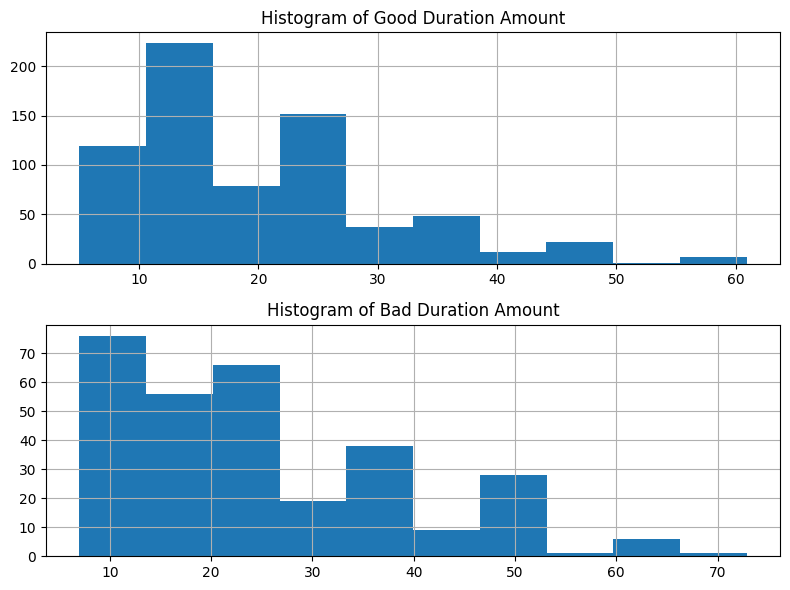

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
good_duration.hist(ax=axes[0])
axes[0].set_title('Histogram of Good Duration Amount')
bad_duration.hist(ax=axes[1])
axes[1].set_title('Histogram of Bad Duration Amount')
plt.tight_layout()
plt.show()

## Conclusion
Since the p-value of 3.244e-12 is less than the alpha threshold of 0.05, we have sufficient evidence to reject the null hypothesis that the mean duration is the same between those that are good credit risks and bad credit risks.